In [10]:
%pip install matplotlib numpy torch torchvision tqdm
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

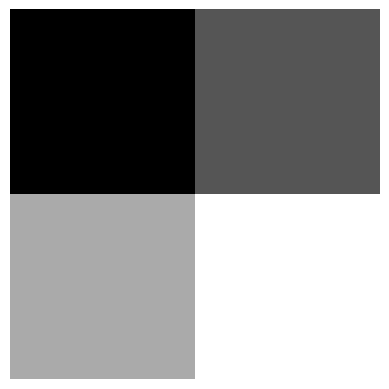

In [12]:
plt.imshow([[1, 2], [3, 4]], cmap='gray')
plt.axis('off')
plt.show()

In [13]:
x_sample, y_sample=mnist_trainset[0]

In [14]:
y_sample

5

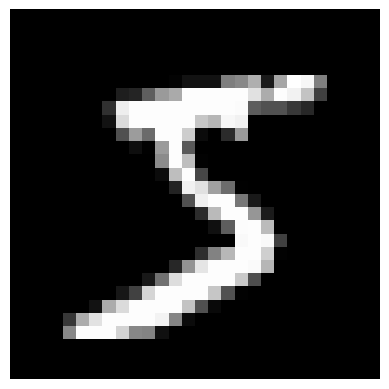

In [15]:
plt.imshow(x_sample, cmap='gray')
plt.axis('off')
plt.show()

In [16]:
torch.tensor(list(x_sample.getdata()), dtype=torch.float32)

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   

# Schritte
- Dataset bauen
- Modell bauen
- Loss-Funktion, Optimizer
 -Trainingsschleife

In [17]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, ds):
        self.ds=ds  

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        # self.ds ist ein Dataset besteht aus Tupeln (x, y) wobei x jeweils ein PIL-Image ist
        x, y=self.ds[idx]
        y=torch.tensor(y)


        # get values of pil image x
        x=torch.tensor(list(x.getdata()), dtype=torch.float32)

        # Ziel: x: als Tensor mit 784 Elementen, y: als Tensor mit 1 Element
        return x, y
    
# dataset_sample=MyDataset(mnist_trainset)
# x, y=dataset_sample[0]
# print("x.shape:", x.shape)          # torch.Size([784])
# print("y:", y)                      # tensor(5)

# image=x.reshape(28, 28)
# plt.imshow(image, cmap='gray')
# plt.axis('off')
# plt.show()

Epoch 1/10 | Loss: 0.3265
Epoch 2/10 | Loss: 0.2456
Epoch 3/10 | Loss: 0.1856
Epoch 4/10 | Loss: 0.2037
Epoch 5/10 | Loss: 0.2278
Epoch 6/10 | Loss: 0.1613
Epoch 7/10 | Loss: 0.1225
Epoch 8/10 | Loss: 0.0916
Epoch 9/10 | Loss: 0.0579
Epoch 10/10 | Loss: 0.0629


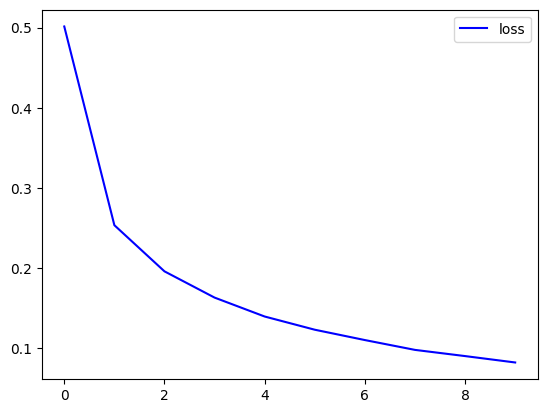

In [18]:
# 1. Schritt: Modell definieren
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=torch.nn.Linear(784, 128)
        self.l2=torch.nn.Linear(128, 10)     # Fully-Connected-Layer mit 10 Eingangsneuronen und 1 Ausgangsneuronen
        self.batch_norm = torch.nn.BatchNorm1d(128)  # Batch-Normalization-Layer mit 128 Neuronen
        self.relu=torch.nn.ReLU()   # ReLU-Aktivierungsfunktion
    
    def forward(self, xb):
        xb = self.relu(self.l1(xb))   # a2
        xb = self.batch_norm(xb)  # a2_norm=a2-mean/std
        xb = self.l2(xb)
        return xb

# 2. Schritt: Modell instanziieren

model=MyModel()

# 3. Schritt: Optimierer definieren
optimizer=torch.optim.SGD(model.parameters(), lr=0.01)

# 4. Schritt: X und y in DataLoader verpacken
data = MyDataset(mnist_trainset)

data_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)


# 5. Schritt: Loss-Funktion definieren
loss_func=torch.nn.CrossEntropyLoss()

# 6. Schritt: Training
n_epochs=10
losses=[]
for epoch in range(n_epochs):
    losses_in_epoch=[]

    for x, y in data_loader:
        y_hat=model(x)
        loss=loss_func(y_hat, y)
        losses_in_epoch.append(loss.item())
        loss.backward()
        with torch.no_grad():
            optimizer.step()
            optimizer.zero_grad()
    losses.append(sum(losses_in_epoch)/len(losses_in_epoch))
    print(f"Epoch {epoch+1}/{n_epochs} | Loss: {loss.item():.4f}")

plt.plot(range(n_epochs),losses, color="blue")
plt.legend(["loss", "rmse_test"])
plt.show()

In [19]:
# 7. Schritt: Testen
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
test_data = MyDataset(mnist_testset)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

n_correct=0
n_total=0
for x, y in test_loader:
    y_hat=model(x)
    n_correct+=(y_hat.argmax(dim=1)==y).sum().item()
    n_total+=len(y)
print(f"Genauigkeit: {n_correct/n_total:.4f}")

Genauigkeit: 0.9669
